# 1. Imports

In [60]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pmdarima import auto_arima

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# 2. Carga de Bases

## 2.1 Base do IPEA (04/01/1986 até 01/07/2024)

[Link para a série do IPEA](http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view)


In [16]:
# Ler o arquivo CSV com a codificação e delimitador corretos
df = pd.read_csv('data/base_de_precos.csv', encoding='ISO-8859-1', delimiter=';', parse_dates=['Data'], dayfirst=True)

# Mostrar as primeiras linhas do DataFrame para verificar se foi lido corretamente
print(df.head())

# Renomear a coluna de preço para um nome mais apropriado, se necessário
df.rename(columns={'Pre\x8do do Bar.': 'Preco_do_Bar'}, inplace=True)

# Configurar a coluna de data como índice
df.set_index('Data', inplace=True)


        Data Preo do Bar.
0 1987-05-20         18,63
1 1987-05-21         18,45
2 1987-05-22         18,55
3 1987-05-25          18,6
4 1987-05-26         18,63


In [17]:
df['Preco_do_Bar'] = df['Preco_do_Bar'].str.replace(',','.').astype(float)
df.dtypes

Preco_do_Bar    float64
dtype: object

## 2.2 Ativos de energia para correlacionar

### XLE: Energy Select Sector SPDR Fund
O **Energy Select Sector SPDR Fund (XLE)** é um fundo negociado em bolsa (ETF) que busca fornecer resultados de investimento que, antes das despesas, correspondam geralmente ao desempenho do índice de Energy Select Sector. Este ETF é projetado para representar o setor de energia da S&P 500, incluindo empresas envolvidas na produção e distribuição de petróleo e gás, equipamentos de perfuração e outros serviços de energia.

### CL=F: WTI Crude Oil
O **WTI Crude Oil (CL=F)**, ou Petróleo Bruto West Texas Intermediate, é um tipo de petróleo bruto usado como referência no preço do petróleo. É extraído e negociado principalmente nos Estados Unidos e é conhecido por sua alta qualidade devido ao seu baixo teor de enxofre e densidade relativamente baixa.

### BZ=F: Brent Crude Oil
O **Brent Crude Oil (BZ=F)** é uma referência importante para o preço do petróleo a nível mundial. Extraído principalmente do Mar do Norte, o Brent é utilizado como referência para os preços de cerca de dois terços das negociações globais de petróleo bruto. O Brent é conhecido por sua qualidade ligeiramente inferior ao WTI, mas é mais amplamente utilizado como padrão global de preços.


In [18]:
# Função para baixar dados de ETFs e índices do Yahoo Finance
def download_yahoo_finance_data(ticker):
    try:
        data = yf.download(ticker, start='1987-05-20', end=datetime.now(), period='1d')
        return data[['Close']]  # Mantém apenas a coluna de fechamento
    except Exception as e:
        print(f"Erro ao baixar dados de {ticker}: {e}")
        return None

# Defina os tickers para os ETFs e índices
tickers = {
    "XLE": "Energy Select Sector SPDR Fund",
    "CL=F": "WTI Crude Oil",
    "BZ=F": "Brent Crude Oil"
}

# Baixe dados de ETFs e índices
finance_data = {}
for ticker, name in tickers.items():
    data = download_yahoo_finance_data(ticker)
    if data is not None:
        finance_data[name] = data.rename(columns={"Close": name})

# Combine todos os dados em um único DataFrame
df_ativos = pd.concat(finance_data.values(), axis=1)
# Criar o DataFrame fechamento_mes com o valor do fechamento do último dia de cada mês
df_ativos_fechamento_mes = df_ativos.resample('M').last()



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/nf/h46zsl3s5msgv8p2r5jywv1c0000gn/T/ipykernel_36865/533420585.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_ativos_fechamento_mes = df_ativos.resample('M').last()


In [19]:
df_ativos.head()

,Energy Select Sector SPDR Fund,WTI Crude Oil,Brent Crude Oil
Date,,,
1998-12-22,23.265625,NaN,NaN
1998-12-23,23.750000,NaN,NaN
1998-12-24,23.625000,NaN,NaN
1998-12-28,23.500000,NaN,NaN
1998-12-29,23.734375,NaN,NaN


In [20]:
df_ativos_fechamento_mes.head()

,Energy Select Sector SPDR Fund,WTI Crude Oil,Brent Crude Oil
Date,,,
1998-12-31,23.343750,NaN,NaN
1999-01-31,21.812500,NaN,NaN
1999-02-28,21.625000,NaN,NaN
1999-03-31,24.593750,NaN,NaN
1999-04-30,28.234375,NaN,NaN


a base df_ativos_fechamento_mes corresponde ao valor do ativo no último dia do mes.

In [21]:
df_ativos['barril'] = df['Preco_do_Bar']

In [22]:
df_ativos

,Energy Select Sector SPDR Fund,WTI Crude Oil,Brent Crude Oil,barril
Date,,,,
1998-12-22,23.265625,NaN,NaN,9.83
1998-12-23,23.750000,NaN,NaN,9.91
1998-12-24,23.625000,NaN,NaN,9.91
1998-12-28,23.500000,NaN,NaN,NaN
1998-12-29,23.734375,NaN,NaN,10.23
...,...,...,...,...
2024-07-08,89.550003,82.330002,85.750000,NaN
2024-07-09,88.760002,81.410004,84.660004,NaN
2024-07-10,89.360001,82.099998,85.080002,NaN


# 3. EDA

## 3.1 Estatísticas descritivas

In [23]:
df_ativos.describe()

,Energy Select Sector SPDR Fund,WTI Crude Oil,Brent Crude Oil,barril
count,6429.000000,5997.000000,4209.000000,6380.000000
mean,57.456514,64.516008,78.740440,64.578966
std,21.083190,25.283166,24.662760,30.077153
min,19.799999,-37.630001,19.330000,9.120000
25%,36.150002,45.340000,59.320000,40.277500
50%,60.000000,63.099998,77.139999,63.110000
75%,74.300003,83.260002,101.260002,84.945000
max,101.290001,145.289993,146.080002,143.950000


### Por que o WTI Crude Oil chegou a ter preço negativo?

O preço negativo do WTI Crude Oil observado nos dados pode ser explicado por um evento histórico ocorrido em abril de 2020. Durante essa época, o mercado de petróleo enfrentou uma situação sem precedentes devido a uma combinação de fatores:

1. **Queda na Demanda Global**: 
   - A pandemia de COVID-19 levou a uma drástica redução na demanda global por petróleo. Com a maioria dos países impondo lockdowns e restrições de viagens, o consumo de petróleo diminuiu significativamente.

2. **Excesso de Oferta**: 
   - Ao mesmo tempo, a produção de petróleo não foi ajustada rapidamente para compensar a queda na demanda. Isso levou a um excesso de oferta no mercado.

3. **Capacidade de Armazenamento**: 
   - O excesso de oferta e a queda na demanda levaram ao esgotamento da capacidade de armazenamento. Os locais onde o petróleo poderia ser armazenado ficaram saturados.

4. **Vencimento dos Contratos Futuros**: 
   - Os preços negativos ocorreram especificamente para os contratos futuros do WTI Crude Oil com vencimento em maio de 2020. Os traders que mantinham esses contratos eram obrigados a aceitar a entrega física do petróleo. Com a falta de espaço de armazenamento, muitos se viram obrigados a pagar para que outros aceitassem a entrega, resultando em preços negativos.

Esses fatores combinados criaram uma situação excepcional onde os preços do petróleo caíram abaixo de zero, algo nunca antes visto na história dos mercados de petróleo.

## 3.2 Série temporal

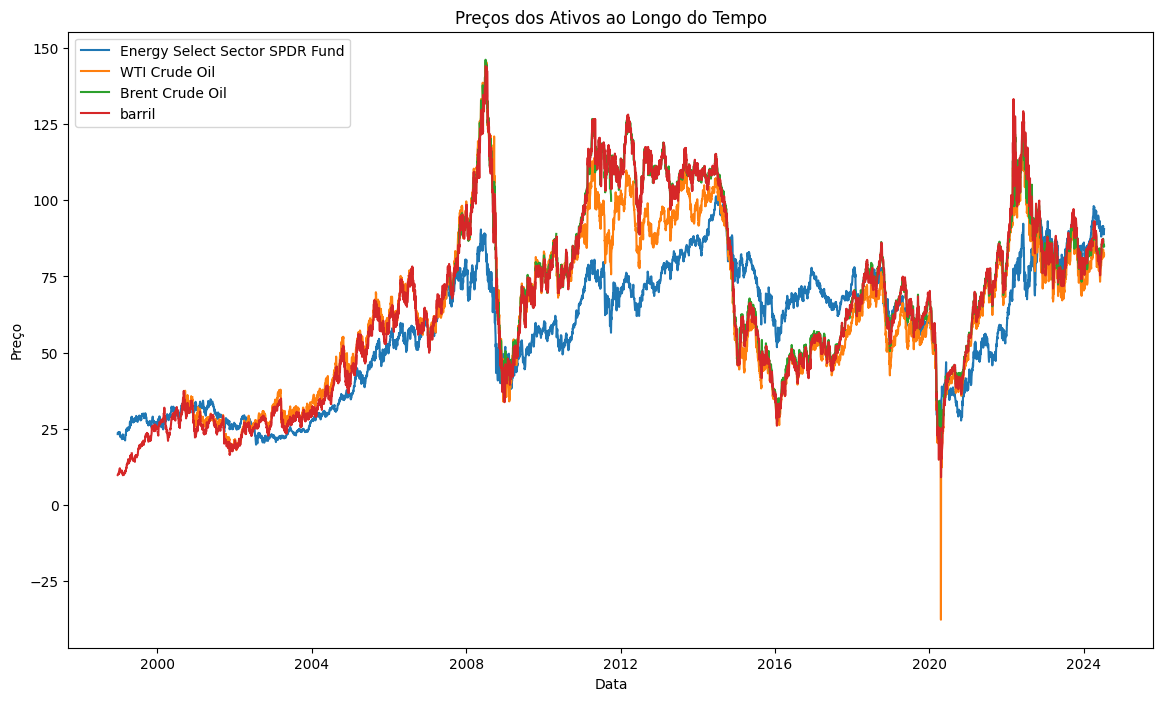

In [24]:
# Visualização de Séries Temporais
plt.figure(figsize=(14, 8))
for column in df_ativos.columns:
    if column != 'Year':  # Excluir a coluna 'Year' da visualização
        plt.plot(df_ativos.index, df_ativos[column], label=column)
plt.title('Preços dos Ativos ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()


### Análise da Série Temporal

1. **Tendência de Alta de Longo Prazo (1998-2008)**:
   - Os preços dos ativos relacionados ao petróleo mostraram uma tendência de alta consistente de 1998 até 2008. Esta tendência pode estar relacionada ao crescimento econômico global e ao aumento da demanda por petróleo.

2. **Crise Financeira Global (2008-2009)**:
   - Em 2008, há uma queda acentuada nos preços dos ativos, coincidente com a crise financeira global. Esta queda foi resultado de uma contração econômica global, que reduziu a demanda por petróleo.

3. **Recuperação Pós-Crise (2009-2014)**:
   - Após a crise de 2008-2009, os preços dos ativos começaram a se recuperar, atingindo novos picos em torno de 2012-2014. Isso pode estar associado à recuperação econômica global e ao aumento da demanda por petróleo.

4. **Queda dos Preços do Petróleo (2014-2016)**:
   - Entre 2014 e 2016, os preços do petróleo caíram significativamente devido a um excesso de oferta global de petróleo, incluindo o aumento da produção de petróleo de xisto nos Estados Unidos.

5. **Oscilações e Recuperação (2016-2019)**:
   - Após a queda de 2014-2016, os preços dos ativos mostraram oscilações, mas mantiveram uma tendência de recuperação moderada até 2019.

6. **Impacto da Pandemia de COVID-19 (2020)**:
   - Em 2020, há uma queda abrupta e temporária nos preços do petróleo, coincidindo com a pandemia de COVID-19. Isso resultou em uma queda drástica na demanda por petróleo devido a lockdowns globais e restrições de viagens, levando até a preços negativos em contratos futuros de petróleo, como observado no WTI Crude Oil.

7. **Recuperação Pós-Pandemia (2021-2024)**:
   - Após o impacto inicial da pandemia, os preços dos ativos voltaram a subir conforme a demanda por petróleo começou a se recuperar. Esta recuperação é visível na série temporal até 2024.

### Insights Específicos:

- **Correlação entre Ativos**:
  - Os preços dos diferentes ativos (Energy Select Sector SPDR Fund, WTI Crude Oil, Brent Crude Oil, e o preço do barril de petróleo Brent) tendem a se mover juntos, indicando alta correlação entre eles. Isso pode ser visto nas tendências e oscilações similares ao longo do tempo.
  
- **Volatilidade**:
  - A volatilidade é evidente em vários períodos, especialmente durante crises econômicas e eventos globais significativos, como a crise financeira de 2008 e a pandemia de COVID-19 em 2020.

- **Resiliência e Recuperação**:
  - O mercado de petróleo mostrou resiliência, com preços se recuperando após quedas significativas. A recuperação pós-crise financeira e pós-pandemia são exemplos notáveis dessa resiliência.

## 3.3 Análise de correlação

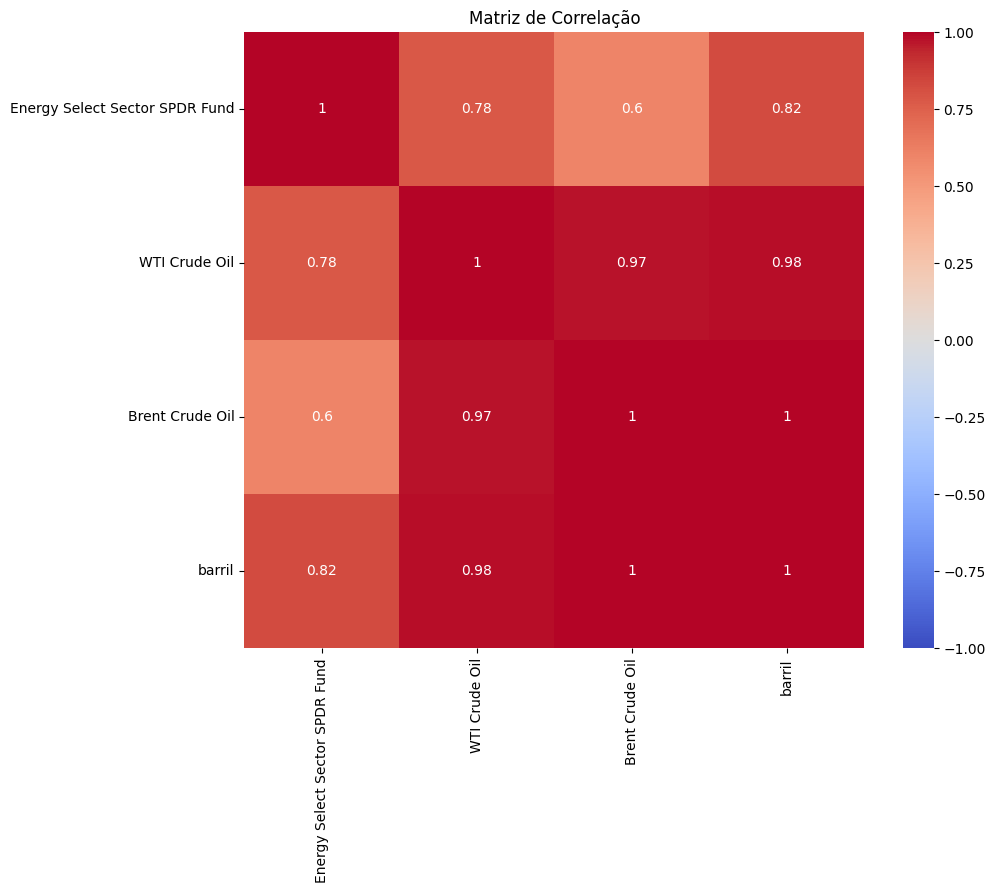

,Energy Select Sector SPDR Fund,WTI Crude Oil,Brent Crude Oil,barril
Energy Select Sector SPDR Fund,1.000000,0.778769,0.597211,0.822582
WTI Crude Oil,0.778769,1.000000,0.973941,0.980815
Brent Crude Oil,0.597211,0.973941,1.000000,0.996401
barril,0.822582,0.980815,0.996401,1.000000


In [25]:
# Calcular a matriz de correlação
correlation_matrix = df_ativos.corr()

# Exibir a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação')
plt.show()

# Mostrar a matriz de correlação como dataframe
correlation_matrix

### Análise da Correlação Focada no Barril

Vamos focar na correlação do preço do barril de petróleo Brent ("barril") com os demais ativos:

1. **Correlação entre Barril e Energy Select Sector SPDR Fund (0.822582)**:
   - **Correlação Positiva Forte**: Uma correlação de 0.82 indica uma relação positiva forte entre o preço do barril de petróleo Brent e o Energy Select Sector SPDR Fund. Isso sugere que, quando o preço do barril aumenta, o preço do fundo de energia também tende a aumentar. Essa relação forte pode ser explicada pelo fato de que empresas dentro do Energy Select Sector SPDR Fund são diretamente afetadas pelos preços do petróleo, que impactam seus custos e receitas.

2. **Correlação entre Barril e WTI Crude Oil (0.980815)**:
   - **Correlação Positiva Muito Forte**: A correlação de 0.98 indica uma relação quase perfeita entre o preço do barril de petróleo Brent e o WTI Crude Oil. Isso significa que os preços dos dois tipos de petróleo tendem a se mover juntos quase exatamente. Essa alta correlação é esperada, dado que ambos são benchmarks globais para preços do petróleo e estão sujeitos a influências semelhantes do mercado global.

3. **Correlação entre Barril e Brent Crude Oil (0.996401)**:
   - **Correlação Positiva Quase Perfeita**: A correlação de 0.996 é praticamente perfeita, o que é intuitivo, pois "barril" refere-se ao preço do Brent Crude Oil. Portanto, qualquer movimento no preço do Brent Crude Oil é refletido diretamente no preço do barril de petróleo Brent. Esta correlação quase perfeita confirma que estamos lidando com dados praticamente idênticos.

## 3.4 Análise de dados ausentes

Contagem de Valores Ausentes por Coluna:
Energy Select Sector SPDR Fund       4
WTI Crude Oil                      436
Brent Crude Oil                   2224
barril                              53
dtype: int64


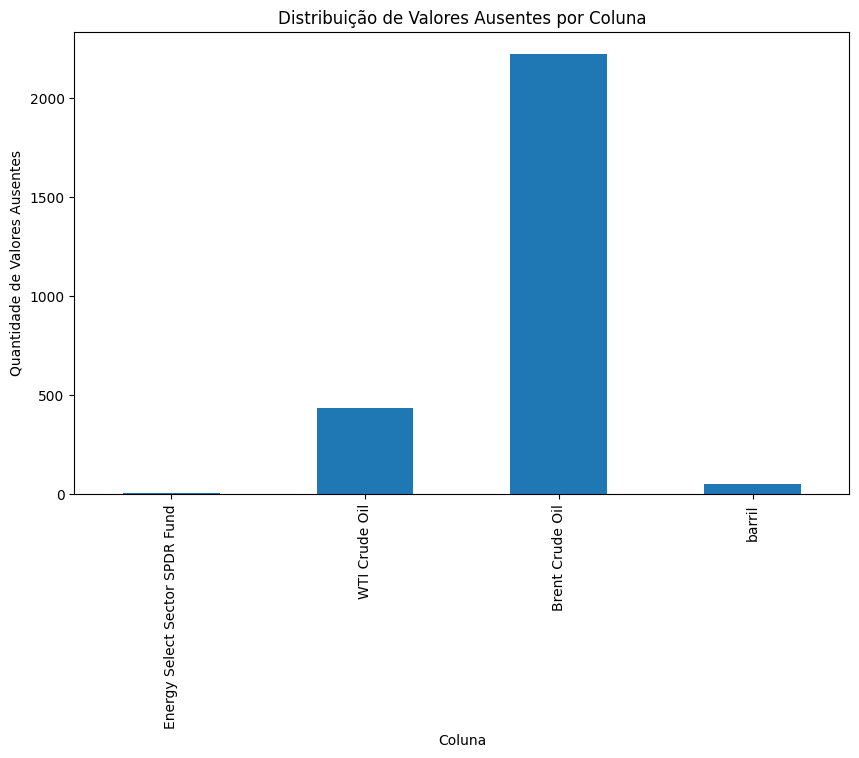

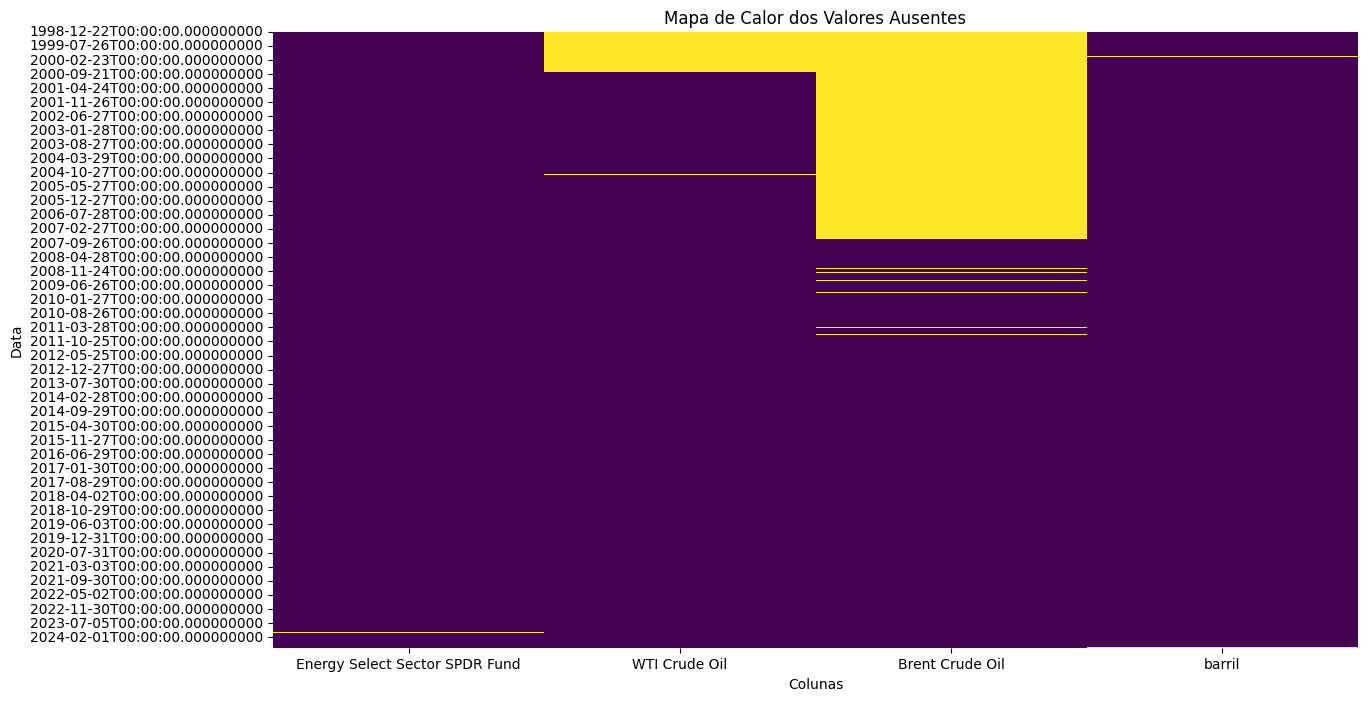

In [26]:
# Contar os Valores Ausentes
missing_values_count = df_ativos.isna().sum()

# Exibir a Contagem de Valores Ausentes
print("Contagem de Valores Ausentes por Coluna:")
print(missing_values_count)

# Visualização da Distribuição dos Valores Ausentes
plt.figure(figsize=(10, 6))
missing_values_count.plot(kind='bar')
plt.title('Distribuição de Valores Ausentes por Coluna')
plt.xlabel('Coluna')
plt.ylabel('Quantidade de Valores Ausentes')
plt.show()

# Mapa de Calor dos Valores Ausentes
plt.figure(figsize=(14, 8))
sns.heatmap(df_ativos.isna(), cbar=False, cmap='viridis')
plt.title('Mapa de Calor dos Valores Ausentes')
plt.xlabel('Colunas')
plt.ylabel('Data')
plt.show()


# 4. Limpeza de dados

Optamos por considerar os dados de 2014 em diante

In [27]:
# Filtrando os dados de 2014 em diante
df_filtered = df_ativos[df_ativos.index >= '2014-01-01']

<Axes: xlabel='Date'>

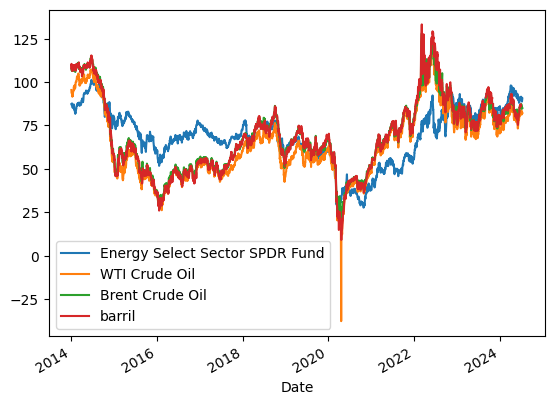

In [28]:
df_filtered.plot()

In [29]:
# Definindo o intervalo de datas a ser deletado
start_date = '2020-03-16'
end_date = '2020-05-13'

# Filtrando e deletando as datas dentro do intervalo
df_filtered = df_filtered.drop(df_filtered.loc[start_date:end_date].index)

<Axes: xlabel='Date'>

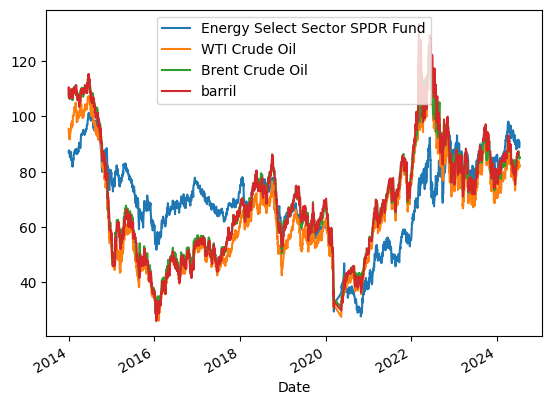

In [30]:
df_filtered.plot()

In [ ]:
df_filtered.isnull.sum()

In [32]:
df_filtered.dropna(inplace=True)

# 4. Criando o Modelo

## 4.1 Decomposição da Série Temporal

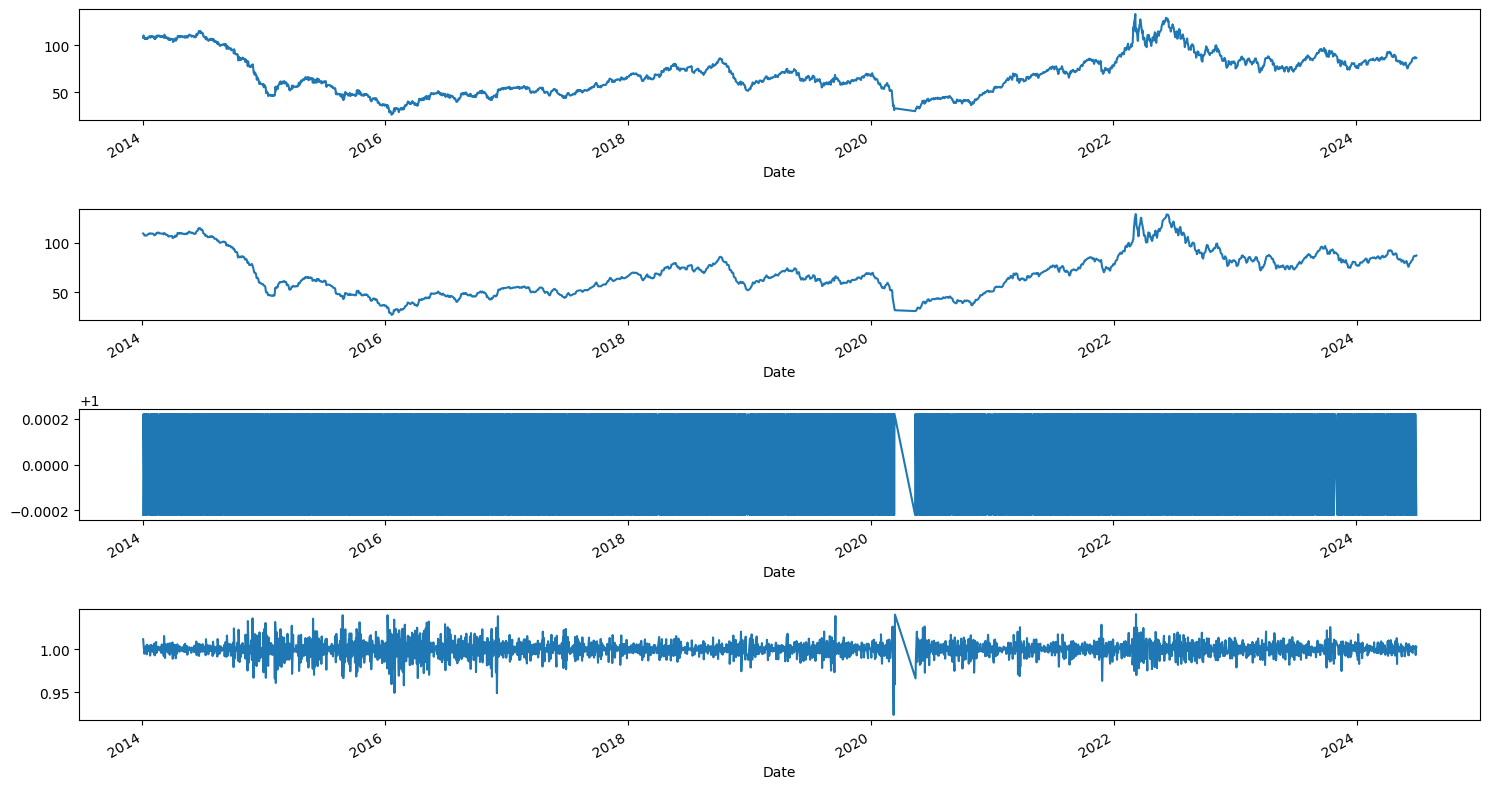

In [44]:
df = df_filtered[['barril']]
seasonplot = seasonal_decompose(df, model='multiplicative', period=2) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

## 4.2 Teste adfuller
Métado para um teste estatístico com a finalidade de aceitar/recusar a hipótese da série ser estacionária

H0 - Hipótese nula (Não é estacionária) H1 - Hipótese alternativa (a série é estacionária)

Quanto maior o p-value, mais evidencia contra a hipótese nula se tem

Rejeitamos a hipótese nula se o p-value for menor que 0.05, ou seja, estamos trabalhando com um intervalode confiança de 95%

In [48]:
# Teste na base completa
sns.set_style('darkgrid')
X = df.barril.values

result = adfuller(X)

print('Teste ADF')
print(f'Teste estatístico: {result[0]}')
print(f'P-value: {result[1]}')
print(f'Valores criticos: ')

for key, value in result[4].items():
    print(f'\t {key}: {value}')

Teste ADF
Teste estatístico: -2.414008733727529
P-value: 0.13782152087377714
Valores criticos: 
	 1%: -3.432919034594598
	 5%: -2.862674995236558
	 10%: -2.5673742003270332


O valor-p não é maior que 0.05 e o teste estatístico é menor que os valores críticos de 1%, 5% e 10%. Então rejeitamos a hipótese nula (H0).

In [51]:
fit_arima = auto_arima(df[['barril']], d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                       seasonal=True,
                       m=6,
                       D=1,
                       start_P=1,
                       start_Q=1,
                       max_P=2,
                       max_Q=2,
                       information_criterion='aic',
                       trace=True,
                       error_action='ignore',
                       stepwise=True)

NameError: name 'auto_arima' is not defined

In [57]:
!pip uninstall numpy

y

Found existing installation: numpy 2.0.0
Uninstalling numpy-2.0.0:
  Would remove:
    /Users/leandro/Documents/git/TECH_CHALLENGE_FASE_4/venv/bin/f2py
    /Users/leandro/Documents/git/TECH_CHALLENGE_FASE_4/venv/bin/numpy-config
    /Users/leandro/Documents/git/TECH_CHALLENGE_FASE_4/venv/lib/python3.11/site-packages/numpy-2.0.0.dist-info/*
    /Users/leandro/Documents/git/TECH_CHALLENGE_FASE_4/venv/lib/python3.11/site-packages/numpy/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [ ]:
!pip install numpy==1.21.0
